##Enhanced Siamese Model with Deeper transformer model and xgboost for selected candidates similarity comparison

- by Nikhil Koganti (Nick)
- SJSU ID: 017550676

In [ ]:
!pip install -U sentence-transformers datasets pandas scikit-learn

In [2]:
!pip install xgboost

In [3]:
# Imports
import pandas as pd
import numpy as np
import re
import random

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
)
from sklearn.linear_model import LogisticRegression

from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
import torch

print("Torch device:", "cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Torch device: cuda


In [4]:
# Load dataset along with label mapping
raw_ds = load_dataset("AzharAli05/Resume-Screening-Dataset")
df = raw_ds["train"].to_pandas()

print("Columns:", df.columns)

print("\nDecision value counts:")
print(df["Decision"].value_counts(dropna=False))

# Drop missing text
df = df[df["Resume"].notna() & df["Job_Description"].notna()].copy()

# Mapping decisions to label (minority class = positive)
vals = df["Decision"].value_counts()
classes = vals.index.tolist()

if len(classes) == 2:
    pos_class = vals.idxmin()
    neg_class = vals.idxmax()
    print(f"\nDetected 2 classes in Decision.")
    print(f"Treating {repr(pos_class)} as POSITIVE (1.0), {repr(neg_class)} as NEGATIVE (0.0).")

    def map_label(x):
        return 1.0 if x == pos_class else 0.0

else:
    print("\nMore than 2 unique Decision values; using simple heuristic mapping.")
    positive_keywords = ["select", "short", "suitable", "advance", "hire", "yes", "1"]

    def map_label(x):
        s = str(x).lower()
        return 1.0 if any(k in s for k in positive_keywords) else 0.0

df["label"] = df["Decision"].apply(map_label).astype(float)

print("\nLabel distribution after mapping:")
print(df["label"].value_counts())
assert df["label"].nunique() == 2, "Label mapping ended up with a single class. Check Decision values."


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

dataset.csv:   0%|          | 0.00/34.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10174 [00:00<?, ? examples/s]

Columns: Index(['Role', 'Resume', 'Decision', 'Reason_for_decision', 'Job_Description'], dtype='object')

Decision value counts:
Decision
reject    5114
select    5060
Name: count, dtype: int64

Detected 2 classes in Decision.
Treating 'select' as POSITIVE (1.0), 'reject' as NEGATIVE (0.0).

Label distribution after mapping:
label
0.0    5114
1.0    5060
Name: count, dtype: int64


In [5]:
# Cleaning functions

def clean_text(text: str) -> str:
    """
    Basic text cleaning: remove emails, lowercase, strip non-alphanum.
    Used for resumes (and as fallback for JDs).
    """
    if not isinstance(text, str):
        return ""
    # Remove emails
    text = re.sub(r'\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b', "", text, flags=re.I)
    # Normalize: lowercase, remove non-alphanum
    text = re.sub(r'[^a-z0-9\s]', ' ', text.lower())
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def clean_job_description(jd: str) -> str:
    """
    Remove feedback-like sentences from a job description.
    Keep requirement-style / skill-related sentences.
    This mitigates data leakage where JD contains manager feedback
    like "had impressive experience", "strong candidate", etc.
    """
    if not isinstance(jd, str):
        return ""

    # Normalize whitespace
    jd = jd.replace("\n", " ").strip()

    # Split into sentences
    sentences = re.split(r'(?<=[.!?]) +', jd)

    cleaned_sentences = []

    # Patterns that indicate feedback-style text we want to REMOVE
    feedback_patterns = [
        r"\bimpressive\b",
        r"\bstrong candidate\b",
        r"\bexceptional(ly)?\b",
        r"\bexcellent\b",
        r"\bperfect fit\b",
        r"\bperformed well\b",
        r"\bperformed exceptionally\b",
        r"\bshowed\b",
        r"\bdemonstrated\b",
        r"\boverall\b",
        r"\bhigh quality\b",
        r"\bprofessionalism\b",
        r"\bgreat enthusiasm\b",
        r"\bpositive attitude\b",
        r"\boutstanding\b",
        r"\bfeedback\b",
        r"\bhiring manager\b",
        r"\brecommend(ed)?\b",
        r"\bwas chosen\b",
        r"\bwas selected\b",
        r"\bthey were selected\b",
        r"\bgood experience\b",
        r"\bimpressed\b",
    ]

    requirement_keywords = [
        r"\bresponsibilit(y|ies)\b",
        r"\brequirement(s)?\b",
        r"\bmust\b",
        r"\bshould\b",
        r"\bexperience\b",
        r"\bknowledge\b",
        r"\bskills?\b",
        r"\bproficient\b",
        r"\beducation\b",
        r"\bbachelor\b",
        r"\bdegree\b",
        r"\bpreferred\b",
        r"\bminimum\b",
        r"\btools?\b",
        r"\btechnolog(y|ies)\b",
        r"\bqualifications?\b",
        r"\brole\b",
        r"\bduties\b"
    ]

    # If no obvious sentence structure, treat whole JD as one chunk
    if len(sentences) == 1:
        sentences = [jd]

    for sentence in sentences:
        s = sentence.strip()
        if not s:
            continue

        s_lower = s.lower()

        # Drop if obviously feedback-like
        if any(re.search(p, s_lower) for p in feedback_patterns):
            continue

        # Keep if requirement-like
        if any(re.search(p, s_lower) for p in requirement_keywords):
            cleaned_sentences.append(s)
            continue

        # Keep if it mentions concrete skills/techs
        if re.search(
            r"\b(python|sql|java|c\+\+|c#|react|angular|node|docker|kubernetes|aws|gcp|azure|ml|machine learning|data|etl|api|design|ui|ux)\b",
            s_lower,
        ):
            cleaned_sentences.append(s)
            continue

    cleaned = " ".join(cleaned_sentences).strip()

    # Fallback: if we removed everything, just do a simple clean of the original text
    if len(cleaned) < 20:
        cleaned = clean_text(jd)

    return cleaned


In [6]:
# Cleaning and filtering resumes

# Clean job descriptions and resume with feedback removal
df["job_clean"] = df["Job_Description"].apply(clean_job_description)
df["resume_clean"] = df["Resume"].apply(clean_text)

# Filter out very short text on either side
df = df[(df["job_clean"].str.len() > 50) & (df["resume_clean"].str.len() > 50)].copy()
df = df.reset_index(drop=True)

print("\nAfter cleaning & length filtering:", len(df))
print("Label distribution:", df["label"].value_counts())



After cleaning & length filtering: 10173
Label distribution: label
0.0    5114
1.0    5059
Name: count, dtype: int64


In [7]:
# Train test split
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)
train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=42, stratify=train_df["label"]
)

print(f"Data Ready: {len(train_df)} Train, {len(val_df)} Val, {len(test_df)} Test\n")

print("Train label distribution:\n", train_df["label"].value_counts())
print("\nVal label distribution:\n", val_df["label"].value_counts())
print("\nTest label distribution:\n", test_df["label"].value_counts())


Data Ready: 7324 Train, 814 Val, 2035 Test

Train label distribution:
 label
0.0    3682
1.0    3642
Name: count, dtype: int64

Val label distribution:
 label
0.0    409
1.0    405
Name: count, dtype: int64

Test label distribution:
 label
0.0    1023
1.0    1012
Name: count, dtype: int64


In [8]:
# DataLoader with training pairs
train_examples = [
    InputExample(
        texts=[row["job_clean"], row["resume_clean"]],
        label=float(row["label"])
    )
    for _, row in train_df.iterrows()
]

print(f"Created {len(train_examples)} training pairs.")

train_dataloader = DataLoader(
    train_examples,
    shuffle=True,
    batch_size=16
)


Created 7324 training pairs.


In [9]:
# MiniLM + OnlineContrastiveLoss + evaluator
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
print("Base model loaded:", model_name)

train_loss = losses.OnlineContrastiveLoss(
    model=model,
    distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE,
    margin=0.5
)

val_sent1 = val_df["job_clean"].tolist()
val_sent2 = val_df["resume_clean"].tolist()
val_labels = val_df["label"].tolist()

evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=val_sent1,
    sentences2=val_sent2,
    labels=val_labels,
    name="resume-screener-val"
)

print("Evaluator prepared with", len(val_labels), "validation pairs.")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Base model loaded: all-MiniLM-L6-v2
Evaluator prepared with 814 validation pairs.


In [12]:
# Siamese model
num_epochs = 4
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
print("Warmup steps:", warmup_steps)

print("Starting training...")

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path="fine_tuned_resume_model_minilm_online_cleanJD",
    save_best_model=True,
    show_progress_bar=True,
    use_amp=True
)

print("Training complete. Best model saved to 'fine_tuned_resume_model_minilm_online_cleanJD'.")


Warmup steps: 183
Starting training...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nikhil-731 (nikhil-731-san-jose-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Resume-screener-val Cosine Accuracy,Resume-screener-val Cosine Accuracy Threshold,Resume-screener-val Cosine F1,Resume-screener-val Cosine F1 Threshold,Resume-screener-val Cosine Precision,Resume-screener-val Cosine Recall,Resume-screener-val Cosine Ap,Resume-screener-val Cosine Mcc
458,No log,No log,0.568796,0.767971,0.686207,0.699599,0.527152,0.982716,0.624507,0.211842
500,0.936200,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
916,0.936200,No log,0.563882,0.739904,0.686644,0.676752,0.525557,0.990123,0.621903,0.216714
1000,0.762400,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
1374,0.762400,No log,0.574939,0.756026,0.688210,0.710223,0.532432,0.972840,0.640158,0.220663
1500,0.687500,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
1832,0.687500,No log,0.568796,0.752042,0.688889,0.709453,0.526797,0.995062,0.633653,0.231185


/usr/local/lib/python3.12/dist-packages/sentence_transformers/util/tensor.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  a = torch.tensor(a)


Training complete. Best model saved to 'fine_tuned_resume_model_minilm_online_cleanJD'.


In [13]:
# Test evaluation (ROC-AUC, PR-AUC)
fine_tuned_model = SentenceTransformer("fine_tuned_resume_model_minilm_online_cleanJD")

print("Generating Test Embeddings...")
test_jd_vecs = fine_tuned_model.encode(
    test_df["job_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)
test_res_vecs = fine_tuned_model.encode(
    test_df["resume_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

test_scores = np.array([
    cosine_similarity([j], [r])[0][0]
    for j, r in zip(test_jd_vecs, test_res_vecs)
])
y_test = test_df["label"].values

test_auc = roc_auc_score(y_test, test_scores)
test_pr_auc = average_precision_score(y_test, test_scores)

def precision_at_k(y_true, y_scores, k=10):
    idx = np.argsort(y_scores)[::-1][:k]
    return y_true[idx].mean()

p_at_10 = precision_at_k(y_test, test_scores, k=10)
p_at_50 = precision_at_k(y_test, test_scores, k=50)

print("\n--- DEEP LEARNING (MiniLM + OnlineContrastiveLoss, CLEAN JD) RESULTS ---")
print(f"Test ROC-AUC: {test_auc:.4f}")
print(f"Test PR-AUC:  {test_pr_auc:.4f}")
print(f"Test P@10:    {p_at_10:.2f}")
print(f"Test P@50:    {p_at_50:.2f}")


Generating Test Embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]


--- DEEP LEARNING (MiniLM + OnlineContrastiveLoss, CLEAN JD) RESULTS ---
Test ROC-AUC: 0.6515
Test PR-AUC:  0.6810
Test P@10:    1.00
Test P@50:    1.00


In [14]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

# Generate Embeddings for the Training Set (we already have Val/Test from previous cells)
print("Encoding training set (this may take a minute)...")
train_jd_vecs = fine_tuned_model.encode(train_df["job_clean"].tolist(), batch_size=64, show_progress_bar=True)
train_res_vecs = fine_tuned_model.encode(train_df["resume_clean"].tolist(), batch_size=64, show_progress_bar=True)

# Feature Engineering Function
def create_xgb_features(jd_vecs, res_vecs):
    """
    Combines vectors to give XGBoost a rich view of the relationship.
    Features: [JD_Vector, Res_Vector, Absolute_Difference, Cosine_Sim]
    """
    diffs = np.abs(jd_vecs - res_vecs)
    prods = jd_vecs * res_vecs
    cos_sim = np.array([cosine_similarity([j], [r])[0][0] for j, r in zip(jd_vecs, res_vecs)]).reshape(-1, 1)

    return np.hstack([jd_vecs, res_vecs, diffs, prods, cos_sim])

print("Constructing feature matrices...")
X_train_xgb = create_xgb_features(train_jd_vecs, train_res_vecs)
y_train_xgb = train_df["label"].values

X_test_xgb = create_xgb_features(test_jd_vecs, test_res_vecs)
y_test_xgb = test_df["label"].values

print(f"Training Features Shape: {X_train_xgb.shape}")

Encoding training set (this may take a minute)...


Batches:   0%|          | 0/115 [00:00<?, ?it/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

Constructing feature matrices...
Training Features Shape: (7324, 1537)


In [15]:
# Train XGBoost
print("Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_xgb, y_train_xgb)

# Evaluate
y_pred_prob = xgb_model.predict_proba(X_test_xgb)[:, 1]
y_pred_binary = (y_pred_prob > 0.5).astype(int)

xgb_auc = roc_auc_score(y_test_xgb, y_pred_prob)
print(f"\n--- XGBoost Enhanced Performance ---")
print(f"XGBoost ROC-AUC: {xgb_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_xgb, y_pred_binary))

Training XGBoost Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:05:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Enhanced Performance ---
XGBoost ROC-AUC: 0.6517

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.57      0.59      1023
         1.0       0.59      0.61      0.60      1012

    accuracy                           0.59      2035
   macro avg       0.59      0.59      0.59      2035
weighted avg       0.59      0.59      0.59      2035



In [16]:
# Calibration on validation set
print("Encoding validation pairs for calibration...")
val_jd_vecs = fine_tuned_model.encode(
    val_df["job_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)
val_res_vecs = fine_tuned_model.encode(
    val_df["resume_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

val_scores = np.array([
    cosine_similarity([j], [r])[0][0]
    for j, r in zip(val_jd_vecs, val_res_vecs)
])
val_labels = val_df["label"].values

print("Validation scores shape:", val_scores.shape)
print("Validation labels distribution:", np.unique(val_labels, return_counts=True))

X_val = val_scores.reshape(-1, 1)
y_val = val_labels

calib_clf = LogisticRegression()
calib_clf.fit(X_val, y_val)

print("Calibration model trained.")

val_prob = calib_clf.predict_proba(X_val)[:, 1]
print("Validation ROC-AUC (calibrated prob):", roc_auc_score(y_val, val_prob))
print("Validation Brier score:", brier_score_loss(y_val, val_prob))

test_prob = calib_clf.predict_proba(test_scores.reshape(-1, 1))[:, 1]
print("Calibrated Test ROC-AUC:", roc_auc_score(y_test, test_prob))
print("Calibrated Test Brier score:", brier_score_loss(y_test, test_prob))


Encoding validation pairs for calibration...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Validation scores shape: (814,)
Validation labels distribution: (array([0., 1.]), array([409, 405]))
Calibration model trained.
Validation ROC-AUC (calibrated prob): 0.6050891967762383
Validation Brier score: 0.24165346445262867
Calibrated Test ROC-AUC: 0.6514687870674101
Calibrated Test Brier score: 0.24008811904096783


In [ ]:
# Probability scoring function
def score_resume_prob(job_desc: str, resume_txt: str) -> float:
    """
    Given a job description and a resume, return P(pass | job, resume)
    using:
      - fine-tuned MiniLM Siamese model (cleaned JD)
      - cosine similarity
      - logistic regression calibration
    """
    j_c = clean_job_description(job_desc)
    r_c = clean_text(resume_txt)

    emb = fine_tuned_model.encode([j_c, r_c])
    sim = cosine_similarity([emb[0]], [emb[1]])[0][0]

    prob_pass = calib_clf.predict_proba([[sim]])[0, 1]
    return float(prob_pass)

# Quick sanity check
job = "Data Scientist role requiring Python, SQL, machine learning, and statistics."
good_res = """
Data Scientist with 3 years of experience.
Strong in Python (pandas, scikit-learn), SQL, regression, classification, and A/B testing.
Built machine learning models for churn prediction and recommendation systems.
"""

bad_res = """
Senior Chef with 10 years of experience leading kitchen staff.
Expert in Italian cuisine, menu design, inventory, and staff scheduling.
"""

print("Good resume probability:", f"{score_resume_prob(job, good_res):.3f}")
print("Bad  resume probability:", f"{score_resume_prob(job, bad_res):.3f}")


In [ ]:
# Raw cosine similarity scores
def score_resume_dl(job_desc: str, resume_txt: str) -> float:
    """
    Raw cosine similarity scorer using the fine-tuned model.
    Mostly for debugging / robustness experiments.
    """
    j_c = clean_job_description(job_desc)
    r_c = clean_text(resume_txt)
    embeddings = fine_tuned_model.encode([j_c, r_c])
    score = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return float(score)


In [ ]:
# Seasoned engineers and roles robustness test
job_text = "Senior Software Engineer. Requires Python, AWS, and System Design experience."

bad_resume = """
fresh graduate with no experience.
skills: microsoft word, typing.
"""

hacked_resume = """
as a seasoned fresh graduate with no experience.
skills: microsoft word, typing.
"""

print("Scoring Bad Resume...")
score_bad = score_resume_dl(job_text, bad_resume)

print("Scoring Hacked Resume...")
score_hacked = score_resume_dl(job_text, hacked_resume)

print("\n" + "="*30)
print(f"Original Score: {score_bad:.4f}")
print(f"Hacked Score:   {score_hacked:.4f}")
print(f"Difference:     {score_hacked - score_bad:.4f}")
print("="*30)

if (score_hacked - score_bad) > 0.05:
    print("WARNING: The word 'seasoned' still gives a massive boost.")
else:
    print("SUCCESS: The 'seasoned' leak appears fixed or negligible.")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import numpy as np

# Generate Embeddings
print("Generating embeddings for the test set..")
test_resume_embeddings = fine_tuned_model.encode(
    test_df["resume_clean"].tolist(), batch_size=64, show_progress_bar=True
)

# Run t-SNE Dimensionality Reduction
print("Running t-SNE to reduce dimensions to 2D...")
tsne = TSNE(
    n_components=2, perplexity=30, max_iter=1000, random_state=42, n_jobs=-1
)
embeddings_2d = tsne.fit_transform(test_resume_embeddings)


# Create dataplots
label_map = {1.0: 'Select (Green)', 0.0: 'Reject (Red)'}
viz_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'Label': test_df["label"].map(label_map)
})

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=viz_df, x='x', y='y', hue='Label',
    palette={'Select (Green)': 'green', 'Reject (Red)': 'red'}, alpha=0.6, s=60
)

plt.title("How the Deep Learning Model 'Sees' Resumes (t-SNE Projection)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Recruiter Decision")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
from sentence_transformers import util
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

# Get Test Scores and Labels
print("Generating scores for graphs...")
test_embeddings_resume = fine_tuned_model.encode(test_df["resume_clean"].tolist())
test_embeddings_job = fine_tuned_model.encode(test_df["job_clean"].tolist())

# Calculate Cosine Similarity
scores = [util.cos_sim(j, r)[0][0].item() for j, r in zip(test_embeddings_job, test_embeddings_resume)]
test_df["predicted_score"] = scores

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=test_df, x="predicted_score",
    hue="label", bins=30,
    kde=True, palette={1.0: 'green', 0.0: 'red'},
    element="step", alpha=0.3
)
plt.title("The 'Gray Zone': Score Distribution of Selects vs. Rejects")
plt.xlabel("Model Similarity Score (0.0 to 1.0)")
plt.ylabel("Number of Resumes")
plt.axvline(x=0.5, color='black', linestyle='--', label="Default Threshold (0.5)")
plt.legend(title="Recruiter Decision", labels=["Select", "Reject"])
plt.show()

# Calibration Curve
prob_true, prob_pred = calibration_curve(test_df["label"], test_df["predicted_score"], n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Your Model', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
plt.title("Calibration Curve: Can we trust the percentage?")
plt.xlabel("Mean Predicted Score")
plt.ylabel("Fraction of Positives (Actual Success Rate)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Load MiniLM + OnlineContrastiveLoss + evaluator
model_name = "all-mpnet-base-v2"
model = SentenceTransformer(model_name)
print("Base model loaded:", model_name)

train_loss = losses.OnlineContrastiveLoss(
    model=model,
    distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE,
    margin=0.5
)

val_sent1 = val_df["job_clean"].tolist()
val_sent2 = val_df["resume_clean"].tolist()
val_labels = val_df["label"].tolist()

evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=val_sent1,
    sentences2=val_sent2,
    labels=val_labels,
    name="resume-screener-val"
)

print("Evaluator prepared with", len(val_labels), "validation pairs.")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Base model loaded: all-mpnet-base-v2
Evaluator prepared with 814 validation pairs.


In [20]:
# Train the Siamese model
num_epochs = 8
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
print("Warmup steps:", warmup_steps)

print("Starting training...")

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path="fine_tuned_resume_model_minilm_online_cleanJD",
    save_best_model=True,
    show_progress_bar=True,
    use_amp=True
)

print("Training complete. Best model saved to 'fine_tuned_resume_model_minilm_online_cleanJD'.")

Warmup steps: 366
Starting training...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Resume-screener-val Cosine Accuracy,Resume-screener-val Cosine Accuracy Threshold,Resume-screener-val Cosine F1,Resume-screener-val Cosine F1 Threshold,Resume-screener-val Cosine Precision,Resume-screener-val Cosine Recall,Resume-screener-val Cosine Ap,Resume-screener-val Cosine Mcc
458,No log,No log,0.581081,0.761705,0.691189,0.709592,0.528796,0.997531,0.628620,0.244335
500,0.899900,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
916,0.899900,No log,0.581081,0.698983,0.685279,0.611009,0.521236,1.000000,0.645819,0.217148
1000,0.751000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
1374,0.751000,No log,0.588452,0.725950,0.689362,0.708302,0.525974,1.000000,0.651012,0.237874
1500,0.674500,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
1832,0.674500,No log,0.593366,0.735367,0.690311,0.721033,0.531292,0.985185,0.657710,0.233046
2000,0.599100,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
2290,0.599100,No log,0.587224,0.725319,0.689949,0.704126,0.526658,1.000000,0.650008,0.240718
2500,0.514000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log


Training complete. Best model saved to 'fine_tuned_resume_model_minilm_online_cleanJD'.


In [21]:
# Test evaluation (ROC-AUC, PR-AUC, P@10, P@50)
fine_tuned_model = SentenceTransformer("fine_tuned_resume_model_minilm_online_cleanJD")

print("Generating Test Embeddings...")
test_jd_vecs = fine_tuned_model.encode(
    test_df["job_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)
test_res_vecs = fine_tuned_model.encode(
    test_df["resume_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

test_scores = np.array([
    cosine_similarity([j], [r])[0][0]
    for j, r in zip(test_jd_vecs, test_res_vecs)
])
y_test = test_df["label"].values

test_auc = roc_auc_score(y_test, test_scores)
test_pr_auc = average_precision_score(y_test, test_scores)

def precision_at_k(y_true, y_scores, k=10):
    idx = np.argsort(y_scores)[::-1][:k]
    return y_true[idx].mean()

p_at_10 = precision_at_k(y_test, test_scores, k=10)
p_at_50 = precision_at_k(y_test, test_scores, k=50)

print("\n--- DEEP LEARNING (MiniLM + OnlineContrastiveLoss, CLEAN JD) RESULTS ---")
print(f"Test ROC-AUC: {test_auc:.4f}")
print(f"Test PR-AUC:  {test_pr_auc:.4f}")
print(f"Test P@10:    {p_at_10:.2f}")
print(f"Test P@50:    {p_at_50:.2f}")

Generating Test Embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]


--- DEEP LEARNING (MiniLM + OnlineContrastiveLoss, CLEAN JD) RESULTS ---
Test ROC-AUC: 0.6700
Test PR-AUC:  0.6953
Test P@10:    1.00
Test P@50:    1.00


In [22]:
# Calibration on validation set
print("Encoding validation pairs for calibration...")
val_jd_vecs = fine_tuned_model.encode(
    val_df["job_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)
val_res_vecs = fine_tuned_model.encode(
    val_df["resume_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

val_scores = np.array([
    cosine_similarity([j], [r])[0][0]
    for j, r in zip(val_jd_vecs, val_res_vecs)
])
val_labels = val_df["label"].values

print("Validation scores shape:", val_scores.shape)
print("Validation labels distribution:", np.unique(val_labels, return_counts=True))

X_val = val_scores.reshape(-1, 1)
y_val = val_labels

calib_clf = LogisticRegression()
calib_clf.fit(X_val, y_val)

print("Calibration model trained.")

val_prob = calib_clf.predict_proba(X_val)[:, 1]
print("Validation ROC-AUC (calibrated prob):", roc_auc_score(y_val, val_prob))
print("Validation Brier score:", brier_score_loss(y_val, val_prob))

test_prob = calib_clf.predict_proba(test_scores.reshape(-1, 1))[:, 1]
print("Calibrated Test ROC-AUC:", roc_auc_score(y_test, test_prob))
print("Calibrated Test Brier score:", brier_score_loss(y_test, test_prob))

Encoding validation pairs for calibration...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Validation scores shape: (814,)
Validation labels distribution: (array([0., 1.]), array([409, 405]))
Calibration model trained.
Validation ROC-AUC (calibrated prob): 0.6424009176250415
Validation Brier score: 0.24032231992337105
Calibrated Test ROC-AUC: 0.6699633720862842
Calibrated Test Brier score: 0.23783458319169173


In [23]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

print("Encoding training set...")
train_jd_vecs = fine_tuned_model.encode(train_df["job_clean"].tolist(), batch_size=64, show_progress_bar=True)
train_res_vecs = fine_tuned_model.encode(train_df["resume_clean"].tolist(), batch_size=64, show_progress_bar=True)

# Cosine similarity based feature engineering
def create_xgb_features(jd_vecs, res_vecs):
    """
    Combines vectors to give XGBoost a rich view of the relationship.
    Features: [JD_Vector, Res_Vector, Absolute_Difference, Cosine_Sim]
    """
    diffs = np.abs(jd_vecs - res_vecs)

    prods = jd_vecs * res_vecs

    cos_sim = np.array([
        cosine_similarity([j], [r])[0][0]
        for j, r in zip(jd_vecs, res_vecs)
    ]).reshape(-1, 1)

    return np.hstack([jd_vecs, res_vecs, diffs, prods, cos_sim])

print("Constructing feature matrices...")
X_train_xgb = create_xgb_features(train_jd_vecs, train_res_vecs)
y_train_xgb = train_df["label"].values

X_test_xgb = create_xgb_features(test_jd_vecs, test_res_vecs)
y_test_xgb = test_df["label"].values

print(f"Training Features Shape: {X_train_xgb.shape}")

Encoding training set (this may take a minute)...


Batches:   0%|          | 0/115 [00:00<?, ?it/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

Constructing feature matrices...
Training Features Shape: (7324, 3073)


In [24]:
# Train
print("Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_xgb, y_train_xgb)

# Evaluation xgboost
y_pred_prob = xgb_model.predict_proba(X_test_xgb)[:, 1]
y_pred_binary = (y_pred_prob > 0.5).astype(int)

xgb_auc = roc_auc_score(y_test_xgb, y_pred_prob)
print(f"\n--- XGBoost Enhanced Performance ---")
print(f"XGBoost ROC-AUC: {xgb_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_xgb, y_pred_binary))

Training XGBoost Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:14:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Enhanced Performance ---
XGBoost ROC-AUC: 0.6710

Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.60      0.60      1023
         1.0       0.60      0.60      0.60      1012

    accuracy                           0.60      2035
   macro avg       0.60      0.60      0.60      2035
weighted avg       0.60      0.60      0.60      2035



Here, we see some of the model improvements after upgrading the base Sentence Transformer model to a more robust **all-mpnet-base-v2**. We also increased the training epochs from 4 to 8. The new transformer model is more robust with more thorough fine-tuning and increased discriminative and complex embeddings.

Using XGBoost on this transformer embeddings achieved the highest ROC-AUC of **0.6710**. The XGBoost model is efficient at capturing more non-linear relationships provided by the embeddings to gain superior predictive performance.

In [27]:
test_df["resume_length"] = test_df["resume_clean"].apply(len)
test_df["job_length"] = test_df["job_clean"].apply(len)

print("Added 'resume_length' and 'job_length' columns to test_df.")
print("First 5 rows with new columns:")
print(test_df[["label", "resume_length", "job_length"]].head())

Added 'resume_length' and 'job_length' columns to test_df.
First 5 rows with new columns:
      label  resume_length  job_length
8915    1.0           2726          93
4464    1.0           3195         124
1684    1.0           2235        3027
5140    0.0           2511         120
735     1.0           2526         113


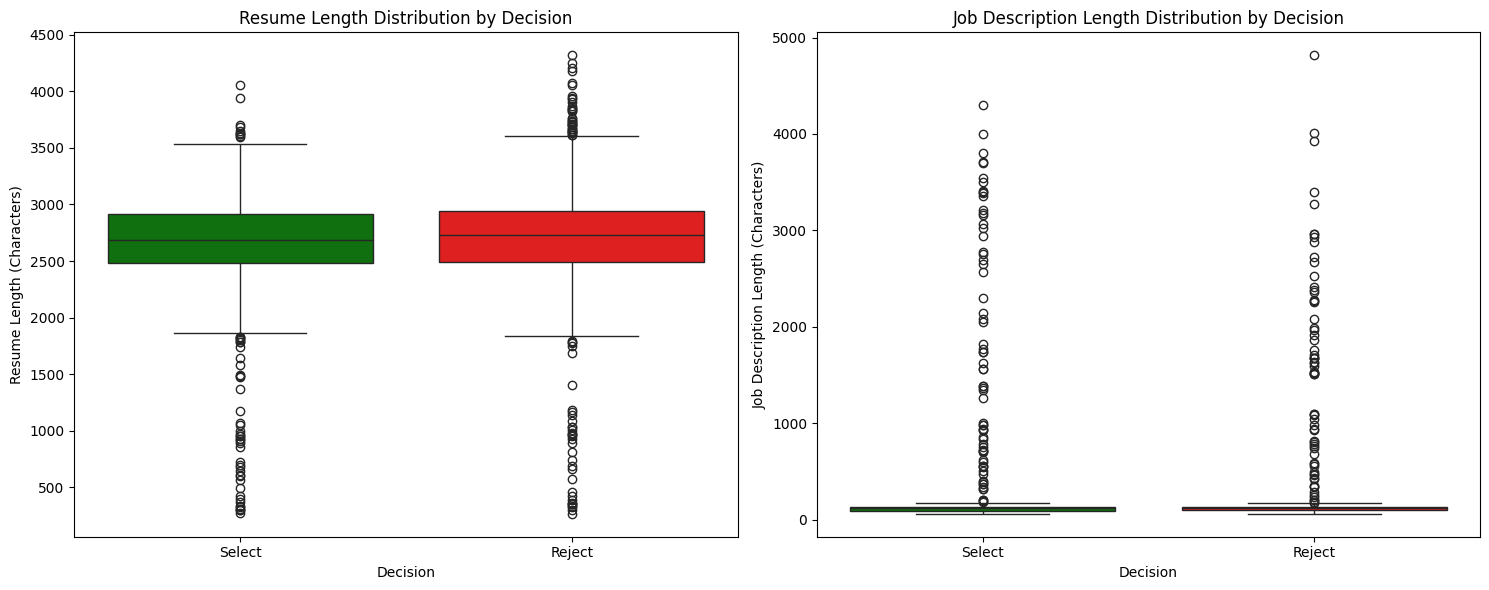

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map numerical labels back to readable strings for plotting
label_map = {1.0: 'Select', 0.0: 'Reject'}
plot_df = test_df.copy()
plot_df['Decision_Label'] = plot_df['label'].map(label_map)

plt.figure(figsize=(15, 6))

# Length Distribution for resume
plt.subplot(1, 2, 1)
sns.boxplot(
    data=plot_df,
    x='Decision_Label',
    y='resume_length',
    hue='Decision_Label',
    palette={'Select': 'green', 'Reject': 'red'},
    legend=False
)
plt.title('Resume Length Distribution by Decision')
plt.xlabel('Decision')
plt.ylabel('Resume Length (Characters)')

# Job Description Length Distribution
plt.subplot(1, 2, 2)
sns.boxplot(
    data=plot_df, x='Decision_Label', y='job_length', hue='Decision_Label',
    palette={'Select': 'green', 'Reject': 'red'}, legend=False
)
plt.title('Job Description Length Distribution by Decision')
plt.xlabel('Decision')
plt.ylabel('Job Description Length (Characters)')
plt.tight_layout()
plt.show()


Number of feature importances: 3073
Number of generated feature names: 3073


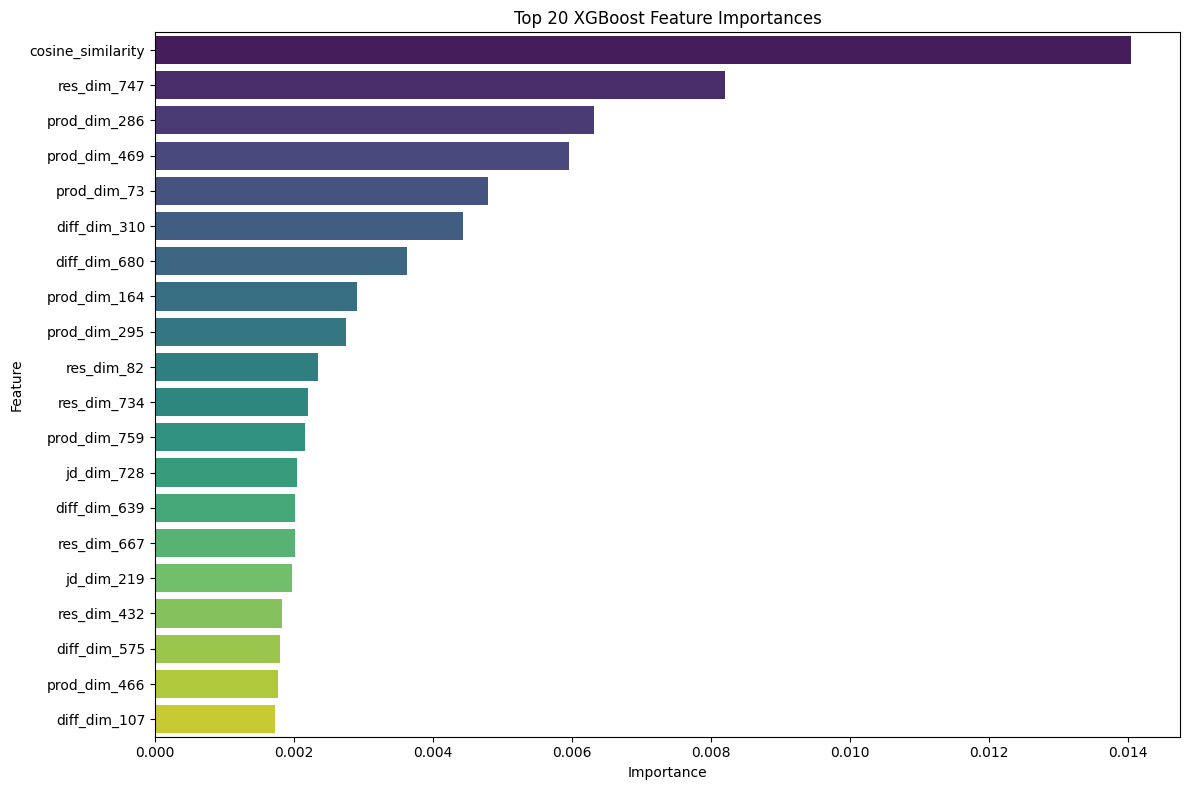

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extract feature importances
feature_importances = xgb_model.feature_importances_

# Create feature names
embedding_dim = fine_tuned_model.get_sentence_embedding_dimension()

feature_names = []
for i in range(embedding_dim):
    feature_names.append(f'jd_dim_{i}')
for i in range(embedding_dim):
    feature_names.append(f'res_dim_{i}')
for i in range(embedding_dim):
    feature_names.append(f'diff_dim_{i}')
for i in range(embedding_dim):
    feature_names.append(f'prod_dim_{i}')
feature_names.append('cosine_similarity')

print(f"Number of feature importances: {len(feature_importances)}")
print(f"Number of generated feature names: {len(feature_names)}")

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# We sort the dataframe based on importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#Visualize top n features
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importance_df.head(top_n), palette='rocket', legend=False)
plt.title(f'Top {top_n} XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


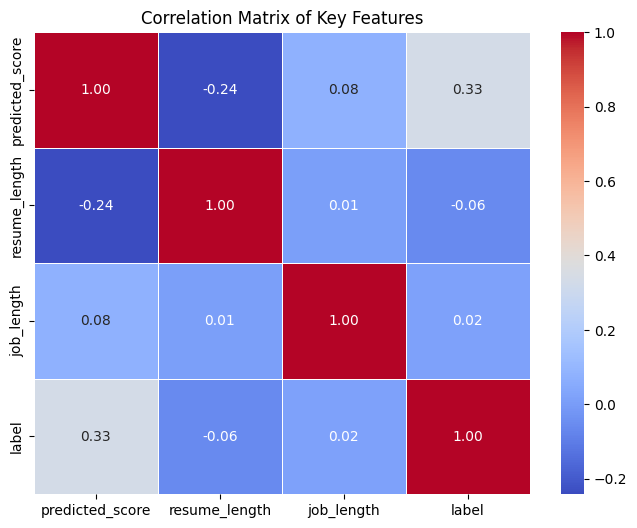

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choosing relevant numerical columns
if 'predicted_score' not in test_df.columns:
    test_df['predicted_score'] = test_scores

correlation_features = test_df[['predicted_score', 'resume_length', 'job_length', 'label']].copy()

correlation_matrix = correlation_features.corr()

# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)

plt.title('Correlation Matrix of Resume Features')
plt.show()


In [33]:
test_df['predicted_score'] = test_prob

print("Updated 'predicted_score' in test_df with calibrated probabilities.")
print(test_df[['label', 'predicted_score']].head())

Updated 'predicted_score' in test_df with calibrated probabilities.
      label  predicted_score
8915    1.0         0.545539
4464    1.0         0.497041
1684    1.0         0.512718
5140    0.0         0.500815
735     1.0         0.498347


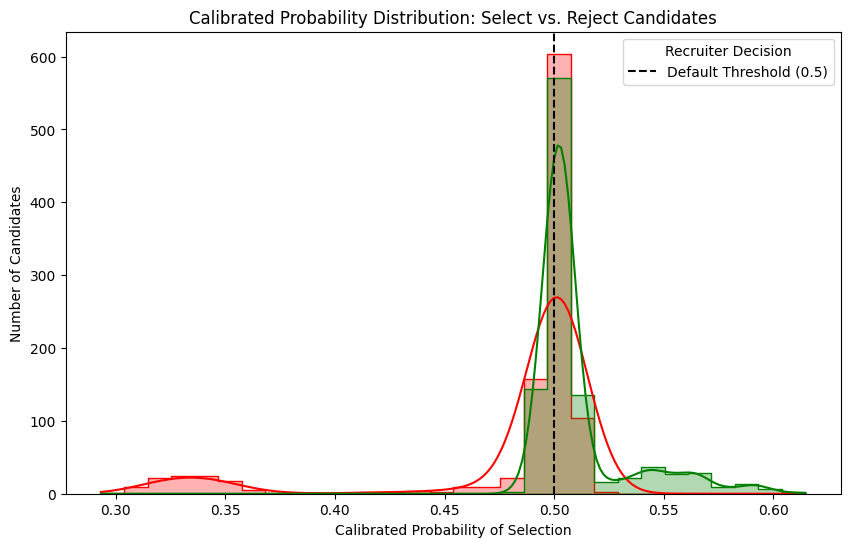

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map numerical labels back to readable strings for plotting
label_map = {1.0: 'Select', 0.0: 'Reject'}
plot_df_calib = test_df.copy()
plot_df_calib['Decision_Label'] = plot_df_calib['label'].map(label_map)

plt.figure(figsize=(10, 6))
sns.histplot(
    data=plot_df_calib,
    x='predicted_score',
    hue='Decision_Label',
    bins=30,
    kde=True,
    palette={'Select': 'green', 'Reject': 'red'},
    element="step",
    alpha=0.3
)
plt.title('Calibrated Probability Distribution: Select vs. Reject Candidates')
plt.xlabel('Calibrated Probability of Selection')
plt.ylabel('Number of Candidates')
plt.axvline(x=0.5, color='black', linestyle='--', label="Default Threshold (0.5)")
plt.legend(title="Recruiter Decision")
plt.show()